### Loading Models

In [1]:
from train_eval import train, evaluate
from model import get_model
from data_utils import get_cifar100_loaders
import torch.nn as nn
import torch.optim as optim
import torch
train_loader, test_loader = get_cifar100_loaders(batch_size=128)
student = get_model('vgg11_bn', pretrained=False)
teacher = get_model('vgg16_bn', pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


### Attaching Hooks

In [2]:
feature_outputs = {'teacher': {}, 'student': {}}

def get_features(name, model_type):
    def hook(model, input, output):
        feature_outputs[model_type][name] = output
    return hook

teacher_layer = teacher.features[22]
student_layer = student.features[13]

teacher_layer.register_forward_hook(get_features('block3_out', 'teacher'))
student_layer.register_forward_hook(get_features('block3_out', 'student'))

### Stage 1

In [3]:
%%writefile feature_kd.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class HintDist(nn.Module):
    def __init__(self, ce_criterion, alpha=0.5, beta=0.5, T=4.0, gamma=0.2):
        super(HintDist, self).__init__()
        self.ce_criterion = ce_criterion
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.T = T

    def forward(self, teacher_logits, student_logits, labels, teacher_feat=None, student_feat=None):
        ce_loss = self.ce_criterion(student_logits, labels)
        log_ps = F.log_softmax(student_logits / self.T, dim=1)
        pt = F.softmax(teacher_logits / self.T, dim=1)
        kd_loss = F.kl_div(log_ps, pt, reduction='batchmean') * (self.T ** 2)
        if self.gamma > 0.0 and teacher_feat is not None and student_feat is not None:
            hint_loss = 0.5 * torch.norm(student_feat - teacher_feat, p='fro')**2
        else:
            hint_loss = torch.tensor(0.0, device=student_logits.device)

        total_loss = self.alpha * ce_loss + self.beta * kd_loss + self.gamma * hint_loss
        return total_loss, ce_loss.detach(), kd_loss.detach(), hint_loss.detach()


class HintLoss(nn.Module):
    def __init__(self):
        super(HintLoss, self).__init__()

    def forward(self, teacher_feat, student_feat):
        hint_loss = 0.5 * torch.norm(student_feat - teacher_feat, p='fro')**2
        return hint_loss

def freeze_layers_following(model: nn.Module, last_trainable_layer_name: str):
    freeze = False
    for name, param in model.named_parameters():
        if freeze:
            param.requires_grad = False
        if name.startswith(last_trainable_layer_name):
            freeze = True

Overwriting feature_kd.py


In [4]:
from feature_kd import HintLoss, freeze_layers_following
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

student = student.to(device)
teacher = teacher.to(device)
teacher.eval()

# Freeze all layers after the selected feature layer
freeze_layers_following(student, 'features.13')

criterion = HintLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, student.parameters()), lr=1e-4)
epochs = 10

for epoch in range(epochs):
    student.train()
    total_hint = 0.0

    for i, (x, y) in enumerate(train_loader):
        feature_outputs['teacher'].clear()
        feature_outputs['student'].clear()

        x = x.to(device)
        y = y.to(device)

        _ = student(x)
        with torch.no_grad():
            _ = teacher(x)

        teacher_feat = feature_outputs['teacher']['block3_out']
        student_feat = feature_outputs['student']['block3_out']

        if student_feat.shape != teacher_feat.shape:
            student_feat = F.interpolate(student_feat, size=teacher_feat.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(teacher_feat, student_feat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_hint += loss.item()

    avg_hint = total_hint / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Hint Loss: {avg_hint:.6f}")

evaluate(student, test_loader, nn.CrossEntropyLoss())

Epoch 1/10 | Hint Loss: 104022.250844
Epoch 2/10 | Hint Loss: 29580.549582
Epoch 3/10 | Hint Loss: 17789.778433
Epoch 4/10 | Hint Loss: 12420.936606
Epoch 5/10 | Hint Loss: 9978.064482
Epoch 6/10 | Hint Loss: 8766.112607
Epoch 7/10 | Hint Loss: 8092.529440
Epoch 8/10 | Hint Loss: 7772.399053
Epoch 9/10 | Hint Loss: 7492.524741
Epoch 10/10 | Hint Loss: 7338.930145
Eval Loss: 4.6052 | Top-1 Acc: 0.83% | Top-5 Acc: 4.74%


(4.60522512512207, 0.83, 4.74)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import tracemalloc
import matplotlib.pyplot as plt

from feature_kd import HintDist, freeze_layers_following
from train_eval import evaluate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

student = student.to(device)
teacher = teacher.to(device)
teacher.eval()

ce_criterion = nn.CrossEntropyLoss()
criterion = HintDist(ce_criterion, alpha=0.5, beta=0.3, T=4.0, gamma=0.2)

for param in student.parameters():
    param.requires_grad = True

optimizer = optim.Adam(student.parameters(), lr=1e-4)
epochs = 20

train_total_losses, train_ce_losses, train_kd_losses, train_hint_losses = [], [], [], []
train_top1_list, train_top5_list = [], []
val_top1_list, val_top5_list, val_loss_list = [], [], []
gpu_usage, cpu_usage = [], []

for epoch in range(epochs):
    student.train()
    total_loss, total_ce, total_kd, total_hint = 0.0, 0.0, 0.0, 0.0
    correct_top1, correct_top5, total_examples = 0, 0, 0
    start_time = time.time()
    tracemalloc.start()

    for i, (x, y) in enumerate(train_loader):
        feature_outputs['teacher'].clear()
        feature_outputs['student'].clear()

        x = x.to(device)
        y = y.to(device)

        student_logits = student(x)
        with torch.no_grad():
            teacher_logits = teacher(x)

        teacher_feat = feature_outputs['teacher']['block3_out']
        student_feat = feature_outputs['student']['block3_out']

        if student_feat.shape != teacher_feat.shape:
            student_feat = F.interpolate(student_feat, size=teacher_feat.shape[2:], mode='bilinear', align_corners=False)

        loss, ce_loss, kd_loss, hint_loss = criterion(teacher_logits, student_logits, y, teacher_feat, student_feat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_ce += ce_loss.item() * x.size(0)
        total_kd += kd_loss.item() * x.size(0)
        total_hint += hint_loss.item() * x.size(0)

        _, pred_top5 = student_logits.topk(5, dim=1, largest=True, sorted=True)
        correct_top1 += (pred_top5[:, 0] == y).sum().item()
        correct_top5 += pred_top5.eq(y.view(-1, 1)).sum().item()
        total_examples += x.size(0)

    avg_loss = total_loss / total_examples
    avg_ce = total_ce / total_examples
    avg_kd = total_kd / total_examples
    avg_hint = total_hint / total_examples

    train_total_losses.append(avg_loss)
    train_ce_losses.append(avg_ce)
    train_kd_losses.append(avg_kd)
    train_hint_losses.append(avg_hint)

    train_top1 = 100.0 * correct_top1 / total_examples
    train_top5 = 100.0 * correct_top5 / total_examples
    train_top1_list.append(train_top1)
    train_top5_list.append(train_top5)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    cpu_usage.append(peak / 1024**2)
    gpu_usage.append(torch.cuda.memory_allocated() / 1024**2 if device=='cuda' else 0)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} | Total Loss: {avg_loss:.4f} | CE: {avg_ce:.4f} | "
          f"KD: {avg_kd:.4f} | Hint: {avg_hint:.4f} | Train Top1: {train_top1:.2f}% Top5: {train_top5:.2f}% | "
          f"GPU Mem: {gpu_usage[-1]:.1f} MB | CPU Peak: {cpu_usage[-1]:.1f} MB | Time: {elapsed:.1f}s")

    val_loss, val_top1, val_top5 = evaluate(student, test_loader, ce_criterion, device=device)
    val_loss_list.append(val_loss)
    val_top1_list.append(val_top1)
    val_top5_list.append(val_top5)


Epoch 1/20 | Total Loss: 1430.7529 | CE: 4.2898 | KD: 20.3983 | Hint: 7112.4425 | Train Top1: 3.44% Top5: 14.93% | GPU Mem: 242.0 MB | CPU Peak: 2.0 MB | Time: 41.1s
Eval Loss: 3.8968 | Top-1 Acc: 6.61% | Top-5 Acc: 26.55%
Epoch 2/20 | Total Loss: 1368.5547 | CE: 3.8695 | KD: 18.6444 | Hint: 6805.1328 | Train Top1: 8.15% Top5: 29.11% | GPU Mem: 241.4 MB | CPU Peak: 2.0 MB | Time: 41.5s
Eval Loss: 3.6336 | Top-1 Acc: 11.55% | Top-5 Acc: 36.26%
Epoch 3/20 | Total Loss: 1325.3372 | CE: 3.6183 | KD: 17.5967 | Hint: 6591.2453 | Train Top1: 12.11% Top5: 38.19% | GPU Mem: 242.0 MB | CPU Peak: 2.0 MB | Time: 41.9s
Eval Loss: 3.3763 | Top-1 Acc: 15.99% | Top-5 Acc: 44.45%
Epoch 4/20 | Total Loss: 1259.0626 | CE: 3.3946 | KD: 16.7315 | Hint: 6261.7292 | Train Top1: 16.18% Top5: 45.39% | GPU Mem: 240.5 MB | CPU Peak: 2.0 MB | Time: 41.1s
Eval Loss: 3.1851 | Top-1 Acc: 20.14% | Top-5 Acc: 49.99%
Epoch 5/20 | Total Loss: 1196.5936 | CE: 3.1820 | KD: 15.8927 | Hint: 5951.1739 | Train Top1: 20.39% To

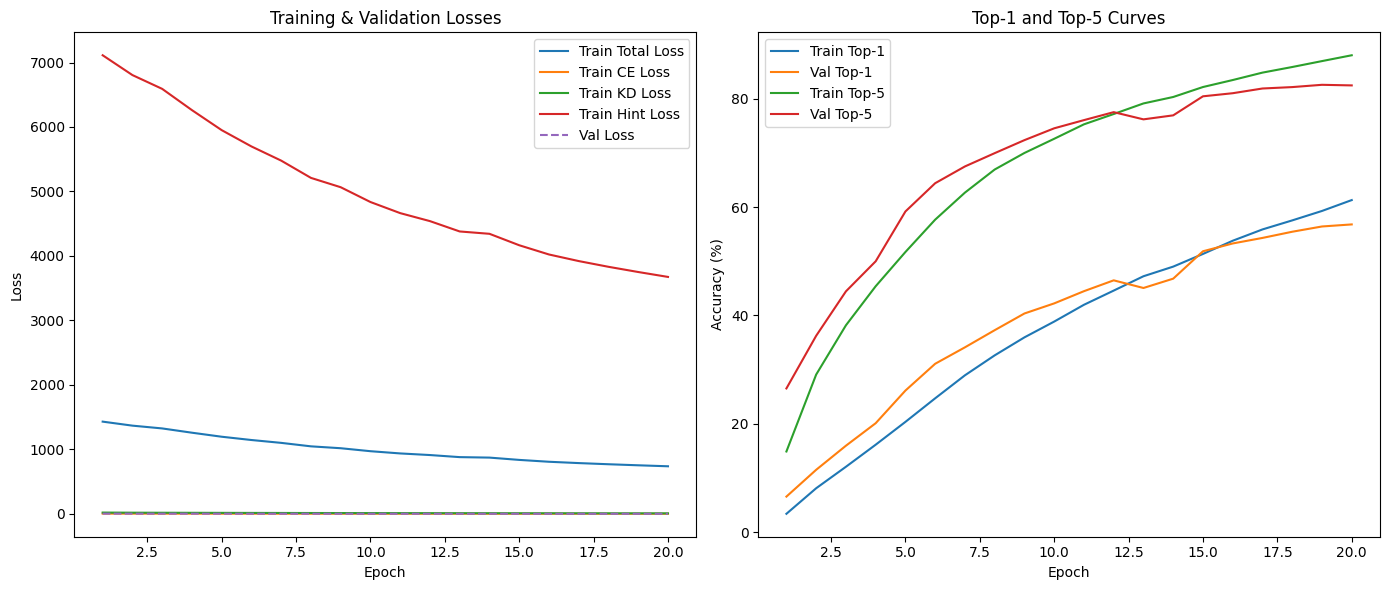

In [6]:
# plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_total_losses, label='Train Total Loss')
plt.plot(epochs_range, train_ce_losses, label='Train CE Loss')
plt.plot(epochs_range, train_kd_losses, label='Train KD Loss')
plt.plot(epochs_range, train_hint_losses, label='Train Hint Loss')
plt.plot(epochs_range, val_loss_list, label='Val Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Losses')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_range, train_top1_list, label='Train Top-1')
plt.plot(epochs_range, val_top1_list, label='Val Top-1')
plt.plot(epochs_range, train_top5_list, label='Train Top-5')
plt.plot(epochs_range, val_top5_list, label='Val Top-5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Curves')
plt.legend()
plt.tight_layout()
plt.show()